In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [6]:
train_data = pd.read_csv('./data/train.csv')
train_y = train_data.target
train_x = pd.DataFrame(train_data.drop(["target", "ID_code"], axis=1)).reset_index(drop=True)

In [7]:
test_data = pd.read_csv('./data/test.csv')

In [8]:
sub = pd.read_csv('./data/sample_submission.csv')

In [9]:
summary = train_data.describe()

Text(0.5, 1.0, 'Histogram of all predictors')

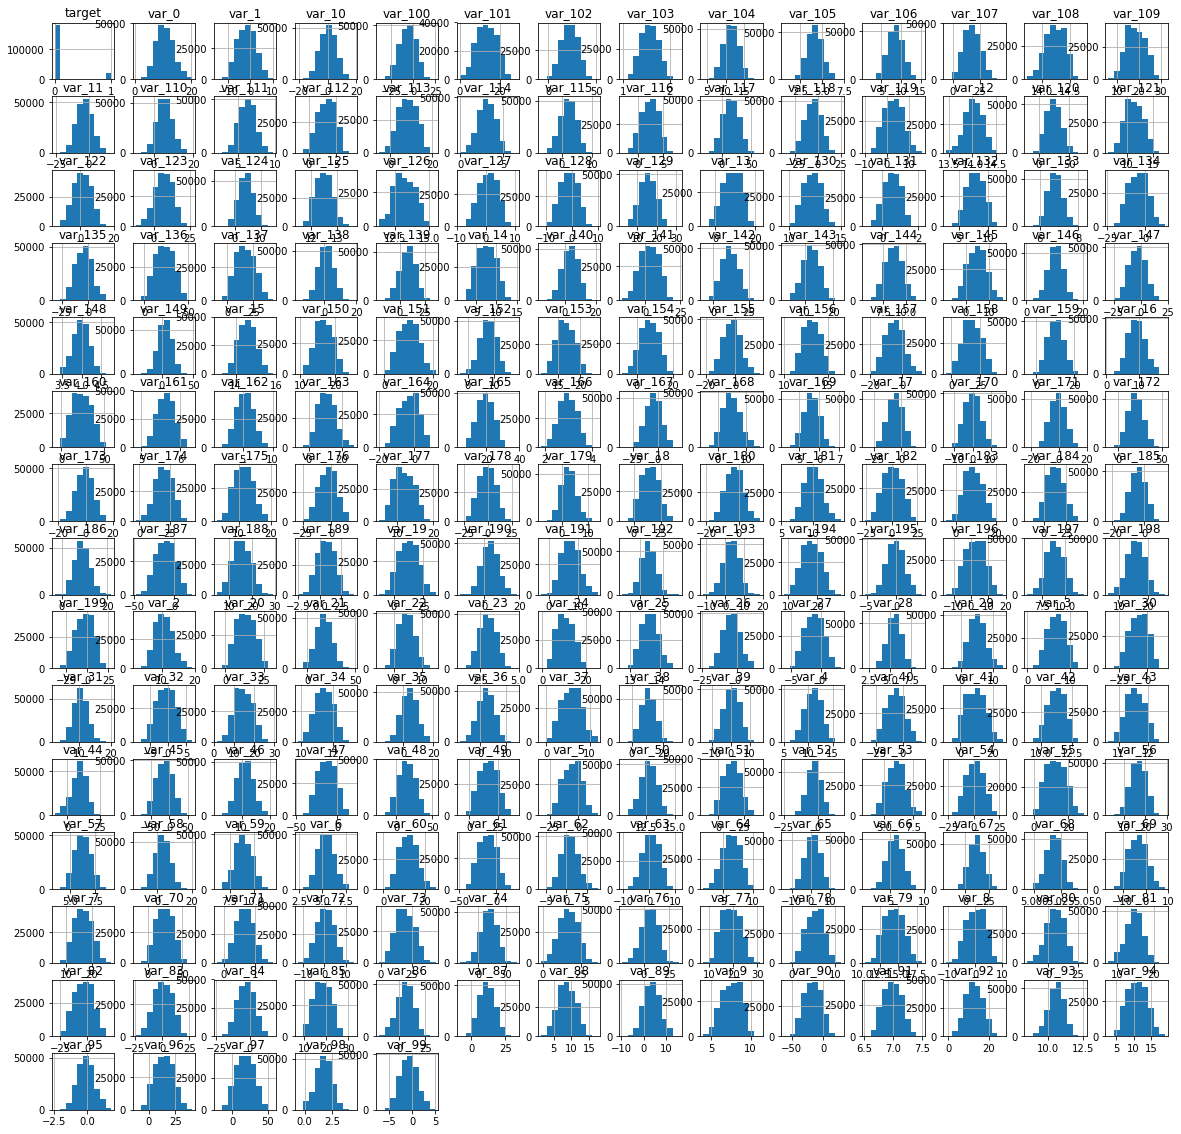

In [20]:
train_data.hist(figsize = (20,20))

plt.tight_layout
plt.title("Histogram of all predictors")

In [11]:
train_data.isnull().sum().sum()

0

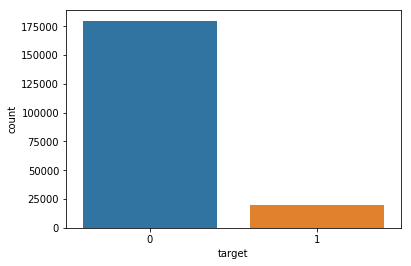

In [21]:
fig = sns.countplot("target", data=train_data)

fig.get_figure().savefig("classImbalance.png")

In [13]:
summary.columns

Index(['target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6',
       'var_7', 'var_8',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=201)

In [14]:
summary.var_0

count    200000.000000
mean         10.679914
std           3.040051
min           0.408400
25%           8.453850
50%          10.524750
75%          12.758200
max          20.315000
Name: var_0, dtype: float64

#### Model Building

I don't think there is any more exploratory needed to be built as the data is normalized to an extent and we can go into the assumption that they are all related.

#### Logistic Regression

In [15]:
logRModel = LogisticRegression(random_state=0).fit(train_x, train_y)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [16]:
logRModel.score(train_x, train_y)

0.91446

In [17]:
ID_Code = test_data["ID_code"]
test_x = pd.DataFrame(test_data.drop(["ID_code"], axis=1)).reset_index(drop=True)

In [18]:
predictions = logRModel.predict(test_x)

In [19]:
sub["target"] = predictions
sub.to_csv("logistic_model_predictions.csv", index=False)

#### Result - 0.630 ROC

### Upsampling data

In [23]:
#Install imblearn: conda install -c conda-forge imbalanced-learn 
from imblearn.over_sampling import SMOTE

In [62]:
print("Before OverSampling, counts of label '1': {}".format(sum(train_y==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(train_y==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(train_x, train_y.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 20098
Before OverSampling, counts of label '0': 179902 

After OverSampling, the shape of train_X: (359804, 200)
After OverSampling, the shape of train_y: (359804,) 

After OverSampling, counts of label '1': 179902
After OverSampling, counts of label '0': 179902


In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(train_y==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(train_y==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(train_x, train_y.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

### LDA Implementation - with upsampled data - lesser score - 0.778 ROC

In [50]:
X_train_datadf=pd.DataFrame(X_train_res)

In [79]:
lda = LinearDiscriminantAnalysis().fit(X_train_datadf, y_train_res)
lda_score1=lda.score(X_train_datadf, y_train_res)
sub["target"] = lda.predict(test_x)
sub.to_csv("lda1.csv", index=False)
lda_score1

0.798915520672366

### LDA Implementation -without upsampling - 0.635 ROC

In [73]:
lda = LinearDiscriminantAnalysis().fit(train_x, train_y)
lda_score2=lda.score(train_x, train_y)
sub["target"] = lda.predict(test_x)
sub.to_csv("lda.csv", index=False)
lda_score2

0.914545

###  Exploration of Correlation - Features are not correlated

In [71]:
corrs = train_x.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.tail(20)

,level_0,level_1,0
39780,var_1,var_80,0.008855
39781,var_80,var_1,0.008855
39782,var_172,var_81,0.008936
39783,var_81,var_172,0.008936
39784,var_122,var_132,0.008956
39785,var_132,var_122,0.008956
39786,var_80,var_6,0.008958
39787,var_6,var_80,0.008958
39788,var_146,var_169,0.009071
39789,var_169,var_146,0.009071


### QDA Implementation -without upsampling - 0.635 ROC

In [77]:
qda = QuadraticDiscriminantAnalysis().fit(train_x, train_y)
qda_score1=qda.score(train_x, train_y)
sub["target"] = qda.predict(test_x)
sub.to_csv("qda.csv", index=False)
qda_score1

0.93277

### QDA Implementation -with upsampling - 0.0 ROC

In [80]:
qda = QuadraticDiscriminantAnalysis().fit(X_train_datadf, y_train_res)
qda_score_us=qda.score(X_train_datadf, y_train_res)
sub["target"] = qda.predict(test_x)
sub.to_csv("qda1.csv", index=False)
qda_score_us

0.8815605162810863